In [1]:
import builtins

In [2]:
# Output path
output_path = '../export/simulators/home_based_trader/'

In [3]:
# Run the input processing notebook to prepare input
%run "../helpers/data-processing.ipynb"

Missing values in the dataset


,Column,Missing Count,Missing Percentage,Action
0,date,0,0.000000,No Missing Values
1,open,0,0.000000,No Missing Values
2,high,0,0.000000,No Missing Values
3,low,0,0.000000,No Missing Values
4,close,0,0.000000,No Missing Values
5,Volume USDT,0,0.000000,No Missing Values
6,tradecount,0,0.000000,No Missing Values
7,ema_5,0,0.000000,No Missing Values
8,ema_15,0,0.000000,No Missing Values
9,ema_30,0,0.000000,No Missing Values


Analyzing feature correlations...

The following features were dropped due to high correlation (threshold: 90%):
- high
- close
- ema_60
- KAMA
- HMA
- ema_30
- WMA
- ema_5
- low
- ema_200
- Z-Score
- ema_15
- ema_100
- MACD_Hist
- open

Performing feature selection using RandomForestClassifier...

Cross-validation accuracy scores: [0.99994 0.99994 0.99994]

Mean accuracy: 0.9999

The following features were selected based on feature importance:
- date
- price
- Volume USDT
- tradecount
- MACD
- MACD_Signal
- ATR
- CMO
- QStick
- price_change_ratio
- high_low_spread

Feature selection process completed.

Shape of X: (1997210, 11)


,date,price,Volume USDT,tradecount,MACD,MACD_Signal,ATR,CMO,QStick,price_change_ratio,high_low_spread
0,1.577837e+09,7180.720,509146.0,140.0,0.728704,-0.152219,4.684925,4.193879,0.120,0.000000,3.69
1,1.577837e+09,7178.470,713540.0,148.0,0.736887,-0.182091,4.698380,0.859360,0.528,-0.000313,3.76
2,1.577837e+09,7179.440,497793.0,104.0,0.846578,-0.117923,4.609025,11.466626,0.493,0.000135,5.60
3,1.577837e+09,7177.175,698627.0,193.0,0.650488,-0.343494,4.398181,-7.962104,-0.425,-0.000315,6.16
4,1.577837e+09,7175.160,241980.0,124.0,0.987398,-0.092457,4.262656,-6.795307,-0.131,-0.000281,3.86
...,...,...,...,...,...,...,...,...,...,...,...
1997205,1.698019e+09,29966.285,482950.0,635.0,-4056.925846,-1909.922487,926.278065,-97.689989,13.189,-0.000401,5.00
1997206,1.698019e+09,29970.500,169682.0,450.0,-3657.565528,-1988.042791,996.882531,-97.688910,24.399,0.000141,5.83
1997207,1.698019e+09,29975.100,111271.0,303.0,-3095.229187,-1922.717147,1072.856572,-97.688328,32.045,0.000153,3.40
1997208,1.698019e+09,29980.890,169741.0,631.0,-2332.807178,-1640.974425,1154.492462,-97.687019,22.669,0.000193,8.21



Shape of y: (1997210,)


0    1
1    0
2    1
3    0
4    0
Name: price_direction, dtype: int64

In [4]:
# Ensure the features and target align
prices = features['price'].values
predictions = target.values        # Binary predictions from target

In [5]:
# Parameters
r = 0.0002  # Expected rate of return
sigma = 0.02  # Base volatility
rolling_window = 14  # Rolling window for metrics
gamma = 0.1  # Adjustment factor for strategy evolution
buy_fee = 0.0025  # 0.25% buy fee
sell_fee = 0.004  # 0.40% sell fee

In [6]:
# Initialize portfolio values
initial_capital = 10000.0  # USD
usd_balance = initial_capital  # Start with all USD
btc_balance = 0.0  # Start with no BTC

In [7]:
# Initialize strategy probabilities
P_buy = np.full(len(prices), 0.5)  # Start with equal probabilities
P_sell = np.full(len(prices), 0.5)

In [8]:
# Calculate market signals using rolling metrics
features['momentum'] = features['price_change_ratio']
features['ATR'] = features['ATR']
features['MACD_signal'] = features['MACD'] - features['MACD_Signal']

In [9]:
# Iterate through each row to simulate trades
actions = []
trade_percentages = []
usd_balances = []
btc_balances = []

for t in range(len(prices)):
    # Adjust strategy probabilities dynamically based on market signals
    if t > 0:
        market_signal = features.loc[t, 'MACD_signal']
        P_buy[t] = P_buy[t - 1] + gamma * (market_signal - P_buy[t - 1])
        P_sell[t] = P_sell[t - 1] + gamma * (-market_signal - P_sell[t - 1])

        # Normalize probabilities to sum to 1
        total_prob = P_buy[t] + P_sell[t]
        P_buy[t] /= total_prob
        P_sell[t] /= total_prob

    # Determine action and trade percentage
    current_price = prices[t]
    if P_buy[t] > P_sell[t] and usd_balance > 0:
        # Buy decision
        trade_percentage = min(0.1 * P_buy[t], usd_balance / current_price)
        usd_spent = trade_percentage * usd_balance
        btc_bought = (usd_spent * (1 - buy_fee)) / current_price  # Deduct fees
        usd_balance -= usd_spent
        btc_balance += btc_bought
        actions.append('Buy')
        trade_percentages.append(trade_percentage)

    elif P_sell[t] > P_buy[t] and btc_balance > 0:
        # Sell decision
        trade_percentage = min(0.1 * P_sell[t], btc_balance)
        btc_to_sell = trade_percentage * btc_balance
        usd_gained = btc_to_sell * current_price * (1 - sell_fee)  # Deduct fees
        btc_balance -= btc_to_sell
        usd_balance += usd_gained
        actions.append('Sell')
        trade_percentages.append(trade_percentage)
    else:
        # If no action is taken, add a default value
        actions.append('None')
        trade_percentages.append(0.0)

    # Record balances
    usd_balances.append(usd_balance)
    btc_balances.append(btc_balance)

In [12]:
# Export results
builtins.data = home_trader_df = pd.DataFrame({
    'prices': prices,
    'MACD_signal': features['MACD_signal'],
    'ATR': features['ATR'],
    'momentum': features['momentum'],
    'P_buy': P_buy,
    'P_sell': P_sell,
    'Action': actions,
    'Trade_Percentage': trade_percentages,
    'USD_Balance': usd_balances,
    'BTC_Balance': btc_balances,
})

Trading Log:


,prices,MACD_signal,ATR,momentum,P_buy,P_sell,Action,Trade_Percentage,USD_Balance,BTC_Balance,Total_Capital
0,7180.720,0.880923,4.684925,0.000000,0.500000,0.500000,None,0.000000,10000.000000,0.000000,10000.000000
1,7178.470,0.918978,4.698380,-0.000313,0.602109,0.397891,Buy,0.060211,9397.891328,0.083667,9998.494728
2,7179.440,0.964501,4.609025,0.000135,0.709275,0.290725,Buy,0.070928,8731.322001,0.176279,9996.909462
3,7177.175,0.993981,4.398181,-0.000315,0.819718,0.180282,Buy,0.081972,8015.600005,0.275752,9994.720884
4,7175.160,1.079855,4.262656,-0.000281,0.939702,0.060298,Buy,0.093970,7262.372745,0.380467,9992.282176
...,...,...,...,...,...,...,...,...,...,...,...
1997205,29966.285,-2147.003359,926.278065,-0.000401,-9219.522786,9220.522786,Sell,0.030321,3905.364490,0.029401,4786.416992
1997206,29970.500,-1669.522737,996.882531,0.000141,-9405.025312,9406.025312,Sell,0.029401,3931.168731,0.028537,4786.437287
1997207,29975.100,-1172.512039,1072.856572,0.000153,-9535.304428,9536.304428,Sell,0.028537,3955.481645,0.027723,4786.470915
1997208,29980.890,-691.832752,1154.492462,0.000193,-9612.174733,9613.174733,Sell,0.027723,3978.431155,0.026954,4786.539263


Buy Actions: 988563
Sell Actions: 1008646


Processing Rows: 100%|██████████| 1997210/1997210 [00:41<00:00, 47612.14rows/s]

Trading Simulation Results:


,Final USD Balance,Remaining BTC,Remaining BTC Value (USD),Final Portfolio Value (USD),Profit/Loss,Total Trades Executed,Buy Trades,Sell Trades
0,$4017.96,0.026344 BTC,$790.01,$4807.98,-51.92%,368020,356495,11525


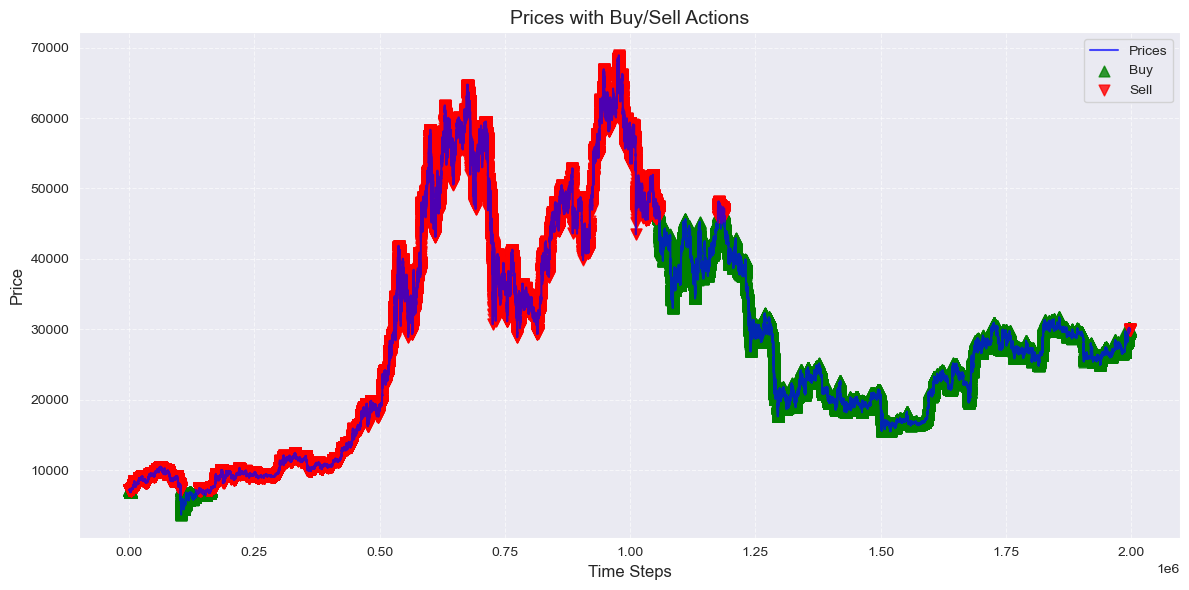

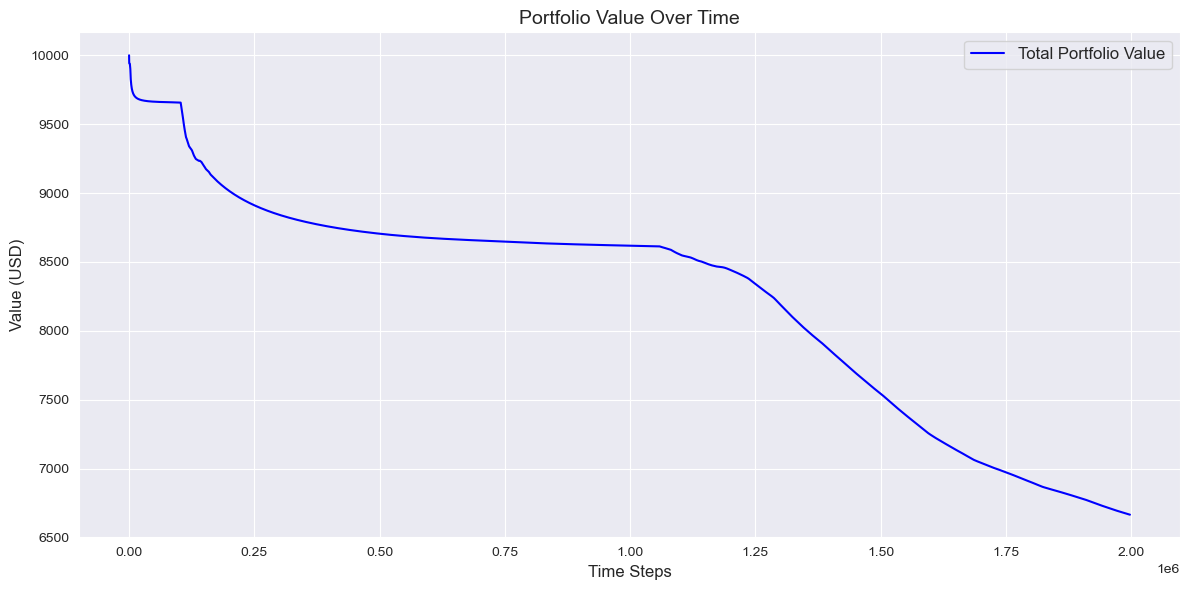

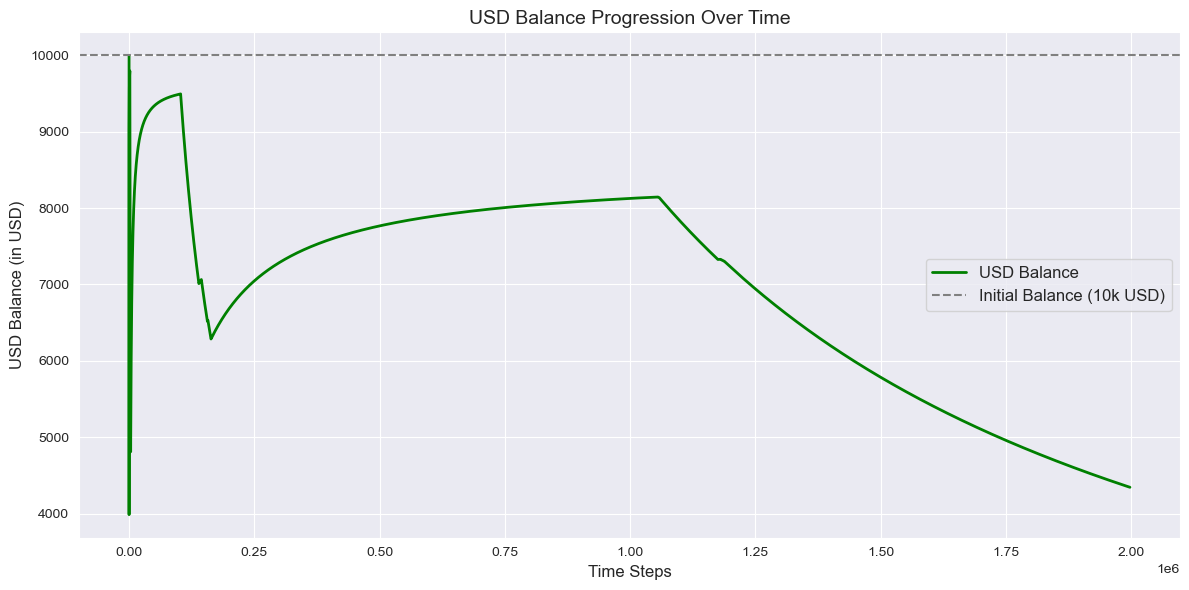

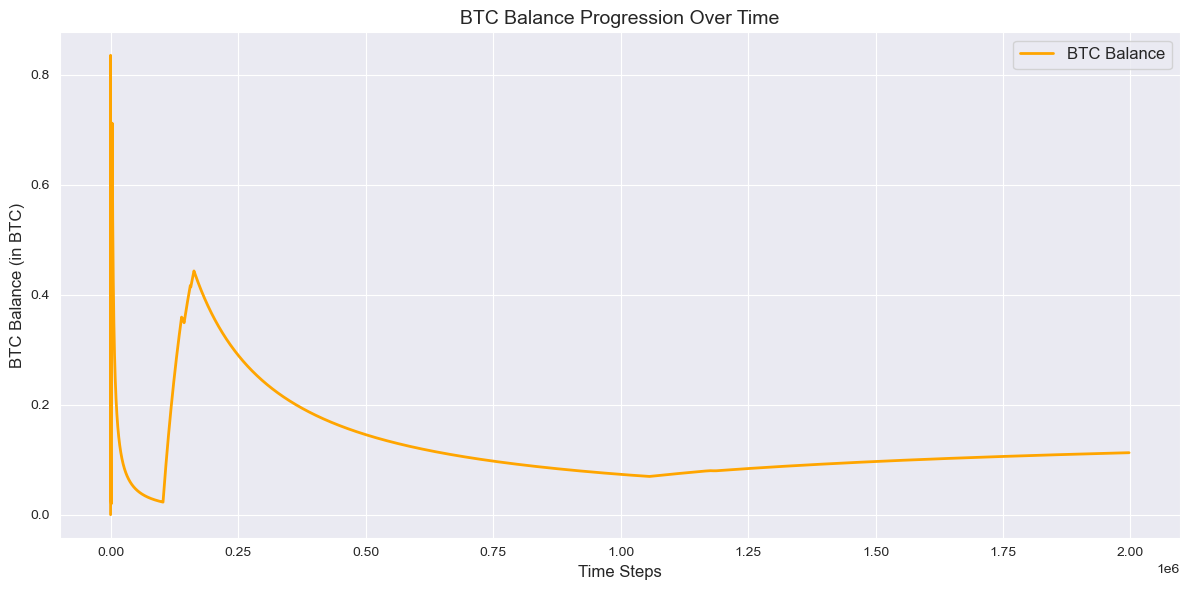

In [19]:
%run "../helpers/trades.ipynb"

In [11]:
%run "../helpers/testing.ipynb"

Data Leakage Check

Data alignment check passed.
Correlation between predictions and future price changes:
                     predictions  future_price_change
predictions             1.000000             0.250137
future_price_change     0.250137             1.000000


Feature Importance Analysis

Feature Importances:
               Feature  Importance
9   price_change_ratio    0.483756
11            momentum    0.479978
8               QStick    0.017276
7                  CMO    0.005198
5          MACD_Signal    0.004598
10     high_low_spread    0.003843
6                  ATR    0.001082
2          Volume USDT    0.000974
4                 MACD    0.000948
3           tradecount    0.000723
12         MACD_signal    0.000667
0                 date    0.000547
1                price    0.000410
Permutation Importances:
               Feature  Importance
9   price_change_ratio    0.263786
11            momentum    0.250783
8               QStick    0.000049
7                  CMO  

NameError: name 'total_capital_history' is not defined

NameError: name 'total_capital_history' is not defined